<div style="text-align: right" align="right"><i>Peter Norvig, 3 Jan 2020</i></div>

# Spelling Bee Puzzle

The [3 Jan. 2020 edition of the 538 Riddler](https://fivethirtyeight.com/features/can-you-solve-the-vexing-vexillology/) concerns the popular NYTimes  [Spelling Bee](https://www.nytimes.com/puzzles/spelling-bee) puzzle:

> In this game, seven letters are arranged in a **honeycomb** lattice, with one letter in the center. Here’s the lattice from Dec. 24, 2019:
> 
> <img src="https://fivethirtyeight.com/wp-content/uploads/2020/01/Screen-Shot-2019-12-24-at-5.46.55-PM.png?w=1136" width="150">
> 
> The goal is to identify as many words as possible that meet the following criteria:
> 1. The word must be at least four letters long.
> 2. The word must include the central letter.
> 3. The word cannot include any letter beyond the seven given letters.
>
>Note that letters can be repeated. For example, the words GAME and AMALGAM are both acceptable words. Four-letter words are worth 1 point each, while five-letter words are worth 5 points, six-letter words are worth 6 points, seven-letter words are worth 7 points, etc. Words that use all of the seven letters in the honeycomb are known as **pangrams** and earn 7 bonus points (in addition to the points for the length of the word). So in the above example, MEGAPLEX is worth 15 points.
>
> ***Which seven-letter honeycomb results in the highest possible game score?*** To be a valid choice of seven letters, no letter can be repeated, it must not contain the letter S (that would be too easy) and there must be at least one pangram.
>
> For consistency, please use [this word list](https://norvig.com/ngrams/enable1.txt) to check your game score.



Since the referenced [word list](https://norvig.com/ngrams/enable1.txt) came from [*my* web site](https://norvig.com/ngrams/enable1.txt), I felt somewhat compelled to solve this one.  (Note I didn't make up the word list; it is a standard Scrabble word list that I happen to host a copy of.) I'll show you how I address the problem, step by step:

# Step 1: Words, Word Scores, and Pangrams

Let's start by defining some basics:

- A **valid word** is a string of at least 4 letters, with no 'S', and not more than 7 distinct letters.
- A **word list** is, well, a list of words.
- A **pangram** is a word with exactly 7 distinct letters; it scores a **pangram bonus** of 7 points.
- The **word score** is 1 for a four letter word, or the length of the word for longer words, plus any pangram bonus.


In [1]:
from typing      import List, Set, Tuple, Dict
from collections import Counter, defaultdict
from dataclasses import dataclass
from itertools   import combinations
import matplotlib.pyplot as plt

In [2]:
Word = str # Type for a word

def valid(word) -> bool:
    """Does word have at least 4 letters, no 'S', and no more than 7 distinct letters?"""
    return len(word) >= 4 and 'S' not in word and len(set(word)) <= 7

def valid_words(text, valid=valid) -> List[Word]: 
    """All the valid words in text."""
    return [w for w in text.upper().split() if valid(w)]

def pangram_bonus(word) -> int: 
    """Does a word get a bonus for having 7 distinct letters?"""
    return 7 if len(set(word)) == 7 else 0

def word_score(word) -> int: 
    """The points for this word, including bonus for pangram."""
    return 1 if len(word) == 4 else len(word) + pangram_bonus(word)

I'll make a mini word list to experiment with: 

In [3]:
mini = valid_words('game amalgam amalgamation glam gem gems em megaplex cacciatore erotica')
mini

['GAME', 'AMALGAM', 'GLAM', 'MEGAPLEX', 'CACCIATORE', 'EROTICA']

Note that `gem` and `em` are too short, `gems` has an `s` which is not allowed, and `amalgamation` has too many distinct letters (8). We're left with six valid words out of the ten candidate words. Here are examples of the other two functions in action:

In [4]:
{w for w in mini if pangram_bonus(w)}

{'CACCIATORE', 'EROTICA', 'MEGAPLEX'}

In [5]:
{w: word_score(w) for w in mini}

{'GAME': 1,
 'AMALGAM': 7,
 'GLAM': 1,
 'MEGAPLEX': 15,
 'CACCIATORE': 17,
 'EROTICA': 14}

# Step 2: Honeycombs and Game Scores

In a honeycomb the order of the letters doesn't matter; all that matters is:
  1. The seven distinct letters in the honeycomb.
  2. The one distinguished center letter.
  
Thus, we can represent a honeycomb as follows:
  

In [6]:
@dataclass(frozen=True, order=True)
class Honeycomb:
    letters: str # 7 letters
    center:  str # 1 letter

hc = Honeycomb('AEGLMPX', 'G')
hc

Honeycomb(letters='AEGLMPX', center='G')

The **game score** for a honeycomb is the sum of the word scores for all the words that the honeycomb can make. How do we know if a honeycomb can make a word? It can if (1) the word contains the honeycomb's center and (2) every letter in the word is in the honeycomb. 

In [7]:
def game_score(honeycomb, wordlist) -> int:
    """The total score for this honeycomb."""
    return sum(word_score(w) 
               for w in wordlist if can_make(honeycomb, w))

def can_make(honeycomb, word) -> bool:
    """Can the honeycomb make this word?"""
    return honeycomb.center in word and all(L in honeycomb.letters for L in word)

In [8]:
game_score(hc, mini)

24

In [9]:
{w: word_score(w) for w in mini if can_make(hc, w)}

{'GAME': 1, 'AMALGAM': 7, 'GLAM': 1, 'MEGAPLEX': 15}

# Step 3: Best Honeycomb

Now that we can compute the game score of a honeycomb, a strategy for finding the best honeycomb is:
 - Compile a list of valid candidate honeycombs.
 - For each one, compute the game score.
 - Return the one with the highest game score.

In [10]:
def best_honeycomb(words) -> Honeycomb: 
    """Return a honeycomb with highest game score on these words."""
    return max(valid_honeycombs(words), 
               key=lambda h: game_score(h, words))

What are the possible candidate honeycombs? We can put any letter in the center, then any 6 letters around the outside (order doesn't matter); since the letter 'S' is not allowed, this gives a total of 25 × (24 choose 6) = 3,364,900 possible honeycombs. 

However, a key constraint of the game is that a valid honeycomb **must make at least one pangram**.  That means that a valid honeycomb must ***be*** the set of seven letters in a pangram (with any of the seven letters as the center). There should be fewer than 3,364,900 of these.

In [11]:
def valid_honeycombs(words) -> List[Honeycomb]:
    """Valid Honeycombs are the pangram lettersets, with any center."""
    pangram_lettersets = {letterset(w) for w in words if pangram_bonus(w)}
    return [Honeycomb(letters, center) 
            for letters in pangram_lettersets 
            for center in letters]

I will represent a **set of letters** as a sorted string of distinct letters. Why not a Python `set` (or `frozenset` to be hashable)? Because a string takes up less space in memory, and its printed representation is  easier to read when debugging. Compare:
- `frozenset({'A', 'E', 'G', 'L', 'M', 'P', 'X'})`
- `'AEGLMPX'`

I'll use the name `letterset` for the function that converts a word to a set of letters, and `Letterset` for the resulting type:

In [12]:
Letterset = str # Type for a set of letters, like "AGLM"

def letterset(word) -> Letterset:
    """The set of letters in a word, represented as a sorted str."""
    return ''.join(sorted(set(word)))

In [13]:
{w: letterset(w) for w in mini}

{'GAME': 'AEGM',
 'AMALGAM': 'AGLM',
 'GLAM': 'AGLM',
 'MEGAPLEX': 'AEGLMPX',
 'CACCIATORE': 'ACEIORT',
 'EROTICA': 'ACEIORT'}

Note that 'AMALGAM' and 'GLAM' have the same letterset, as do 'CACCIATORE' and 'EROTICA'.

In [14]:
valid_honeycombs(mini)

[Honeycomb(letters='ACEIORT', center='A'),
 Honeycomb(letters='ACEIORT', center='C'),
 Honeycomb(letters='ACEIORT', center='E'),
 Honeycomb(letters='ACEIORT', center='I'),
 Honeycomb(letters='ACEIORT', center='O'),
 Honeycomb(letters='ACEIORT', center='R'),
 Honeycomb(letters='ACEIORT', center='T'),
 Honeycomb(letters='AEGLMPX', center='A'),
 Honeycomb(letters='AEGLMPX', center='E'),
 Honeycomb(letters='AEGLMPX', center='G'),
 Honeycomb(letters='AEGLMPX', center='L'),
 Honeycomb(letters='AEGLMPX', center='M'),
 Honeycomb(letters='AEGLMPX', center='P'),
 Honeycomb(letters='AEGLMPX', center='X')]

In [15]:
best_honeycomb(mini)

Honeycomb(letters='ACEIORT', center='A')

**We're done!** We know how to find the best honeycomb. But so far, we've only done it  for the mini word list. 

# Step 4: The enable1 Word List

Here's the real word list, `enable1.txt`, and some counts derived from it:

In [16]:
! [ -e enable1.txt ] || curl -O http://norvig.com/ngrams/enable1.txt
! wc -w enable1.txt

  172820 enable1.txt


In [17]:
enable1 = valid_words(open('enable1.txt').read())
len(enable1)

44585

In [18]:
pangrams = [w for w in enable1 if pangram_bonus(w)]
len(pangrams)

14741

In [19]:
len({letterset(w) for w in pangrams}) # pangram lettersets

7986

In [20]:
len(valid_honeycombs(enable1))

55902

To summarize, there are:

- 172,820 words in the `enable1` word list
- 44,585 valid Spelling Bee words
- 14,741 pangram words 
- 7,986 distinct pangram lettersets
- 55,902 (7 × 7,986) valid pangram-containing honeycombs
- 3,364,900 possible honeycombs (most of which can't make a panagram and thus are invalid)

How long will it take to run `best_honeycomb(enable1)`? Most of the computation time is in `game_score` (each call has to look at all 44,585 valid words), so let's estimate the total time by first checking how long it takes to compute the game score of a single honeycomb:

In [21]:
%timeit game_score(hc, enable1)

8.7 ms ± 96.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Roughly 9 milliseconds on my computer (this may vary). How many seconds would it be to run `game_score` for all 55,902 valid honeycombs?

In [22]:
55902 * 9/1000

503.118

About 500 seconds, or 8 minutes. I could run `best_honeycomb(enable1)`, go take a coffee break, and come back to see the solution and declare victory. But I think that a puzzle like this deserves a more elegant solution. I'd like to get the run time under a minute (as is suggested in [Project Euler](https://projecteuler.net/)), and I have an idea how to do it. (*Note:* I should point out that [William Shunn](https://www.shunn.net/about.html) has a list of [58,838 pangrams](https://www.shunn.net/bee/pangrams.html) that form 20,597 distinct pangram lettersets, so it would take more than twice as long with his dictionary. However, we don't know what dictionary the NY Times is using, so we don't know what words would be accepted.)

# Step 5: Faster Algorithm: Points Table

Here's my plan for a more efficient program:

1. Keep the same strategy of trying every pangram letterset, but do some precomputation that will make `game_score` much faster.
1. The precomputation is: compute the `letterset` and `word_score` for each word, and make a table of `{letterset: total_points}` giving the total number of word score points for all the words that correspond to each letterset. I call this a **points table**.
3. These calculations are independent of the honeycomb, so they need be done only once, not 55,902  times. 
4. `game_score2` takes a honeycomb and a points table as input. The idea is that every word that the honeycomb can make must have a letterset that is the same as a valid **letter subset** of the honeycomb. A valid letter subset must include the center letter, and it may or may not include each of the other 6 letters, so there are exactly $2^6 = 64$ valid letter subsets. The function `letter_subsets(honeycomb)` computes these.
The result of `game_score2` is the sum of the honeycomb's 64 letter subset entries in the points table.

That means that in `game_score2` we no longer need to iterate over 44,585 words and check if each word is a subset of the honeycomb. Instead we iterate over the 64 subsets of the honeycomb and for each one check&mdash;in one table lookup&mdash;whether it is a word (or more than word) and how many total points those word(s) score.  Since 64 is less than 44,585, that's a nice optimization!


Here's the code:

In [23]:
PointsTable = Dict[Letterset, int] # How many points does a letterset score?

def best_honeycomb(words) -> Honeycomb: 
    """Return a honeycomb with highest game score on these words."""
    points_table = tabulate_points(words)
    honeycombs = (Honeycomb(letters, center) 
                  for letters in points_table if len(letters) == 7 
                  for center in letters)
    return max(honeycombs, key=lambda h: game_score2(h, points_table))

def tabulate_points(words) -> PointsTable:
    """Return a Counter of {letterset: points} from words."""
    table = Counter()
    for w in words:
        table[letterset(w)] += word_score(w)
    return table

def letter_subsets(honeycomb) -> List[Letterset]:
    """The 64 subsets of the letters in the honeycomb, each including the center letter."""
    return [letters 
            for n in range(1, 8) 
            for letters in map(''.join, combinations(honeycomb.letters, n))
            if honeycomb.center in letters]

def game_score2(honeycomb, points_table) -> int:
    """The total score for this honeycomb, using a points table."""
    return sum(points_table[letterset] for letterset in letter_subsets(honeycomb))

Let's get a feel for how this works. 

First consider `letter_subsets`. A 4-letter honeycomb makes $2^3 = 8$ subsets; 7-letter honeycombs make $2^6 = 64$ subsets:

In [24]:
letter_subsets(Honeycomb('GLAM', 'G')) 

['G', 'GL', 'GA', 'GM', 'GLA', 'GLM', 'GAM', 'GLAM']

Now `tabulate_points`:

In [25]:
print('mini =', mini)
tabulate_points(mini)

mini = ['GAME', 'AMALGAM', 'GLAM', 'MEGAPLEX', 'CACCIATORE', 'EROTICA']


Counter({'AEGM': 1, 'AGLM': 8, 'AEGLMPX': 15, 'ACEIORT': 31})

The letterset `'AGLM'` gets 8 points, 7 for AMALGAM and 1 for GLAM.  `'ACEIORT'` gets 31 points, 17 for CACCIATORE and 14 for EROTICA. The other lettersets represent one word each. 

Let's make sure we haven't broken the  `best_honeycomb` function:

In [26]:
assert best_honeycomb(mini) == Honeycomb('ACEIORT', 'A')

# Step 6: The Solution

Finally, the solution to the puzzle:

In [27]:
%time best = best_honeycomb(enable1)

CPU times: user 1.65 s, sys: 2.19 ms, total: 1.65 s
Wall time: 1.65 s


In [28]:
best, game_score(best, enable1)

(Honeycomb(letters='AEGINRT', center='R'), 3898)

**Wow! 3898 is a high score!** 

And it took **less than 2 seconds** of computation to find the best honeycomb!

Where does the time go? There's the initial time to do `tabulate_points` once, and then calls to `game_score2` for each candidate honeycomb: 

In [29]:
%time points_table = tabulate_points(enable1)

CPU times: user 66.1 ms, sys: 852 µs, total: 66.9 ms
Wall time: 66.2 ms


In [30]:
%timeit game_score2(Honeycomb('AEGINRT', 'R'), points_table)

25.6 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Step 7: Even Faster Algorithm: Branch and Bound

A run time of less than 2 seconds is pretty good! But I'm not ready to stop now.

Consider the word 'EQUIVOKE'. It is a pangram, but what with the 'Q' and 'V' and 'K', it is not a high-scoring honeycomb, regardless of what center is used:

In [31]:
letters = letterset('EQUIVOKE')
{C: game_score(Honeycomb(letters, C), enable1) for C in letters}

{'E': 48, 'I': 32, 'K': 34, 'O': 36, 'Q': 29, 'U': 29, 'V': 35}

It would be great if we could eliminate all seven of these honeycombs at once, rather than trying each one in turn. So my idea is to:
- Keep track of the best honeycomb and best score found so far.
- For each new pangram letterset, ask "if we weren't required to use the center letter, would this letterset score higher than the best honeycomb so far?" 
- If yes, then try it with all seven centers; if not then discard it immediately.
- This is called a [**branch and bound**](https://en.wikipedia.org/wiki/Branch_and_bound) algorithm: if an **upper bound** of the new letterset's score can't beat the best honeycomb so far, then we prune a whole **branch** of the search tree consisting of the seven honeycombs that have that letterset.

What would the score of a letterset be if we weren't required to use the center letter? It turns out I can make a dummy Honeycomb and specify the empty string for the center, `Honeycomb(letters, '')`, and call `game_score2` on that. This works because of a quirk of Python: we ask if `honeycomb.center in letters`; normally in Python the expression `x in y` means "is `x` a member of the collection `y`", but when `y` is a string it means "is `x` a substring of `y`", and the empty string is a substring of every string. (If I had represented a letterset as a Python `set`, this wouldn't work.)

Thus, I can rewrite `best_honeycomb` as follows:

In [32]:
def best_honeycomb2(words) -> Honeycomb: 
    """Return a honeycomb with highest game score on these words."""
    points_table = tabulate_points(words)
    best, best_score = None, 0
    pangrams = (s for s in points_table if len(s) == 7)
    for p in pangrams:
        if game_score2(Honeycomb(p, ''), points_table) > best_score:
            for center in p:
                honeycomb = Honeycomb(p, center)
                score = game_score2(honeycomb, points_table)
                if score > best_score:
                    best, best_score = honeycomb, score
    return best

In [33]:
%time best_honeycomb2(enable1)

CPU times: user 373 ms, sys: 1.32 ms, total: 374 ms
Wall time: 374 ms


Honeycomb(letters='AEGINRT', center='R')

Same honeycomb for the answer, but four times faster–less than 0.4 second.

# Step 8: Curiosity

I'm curious about a bunch of things.

### What's the highest-scoring individual word?

In [34]:
max(enable1, key=word_score)

'ANTITOTALITARIAN'

### What are some of the pangrams?

In [35]:
pangrams[::500] # Every five-hundreth pangram

['AARDWOLF',
 'ANCIENTER',
 'BABBLEMENT',
 'BIVARIATE',
 'CABEZON',
 'CHEERFUL',
 'COLLOGUING',
 'CRANKLE',
 'DEMERGERING',
 'DWELLING',
 'ETYMOLOGY',
 'FLATTING',
 'GARROTTING',
 'HANDIER',
 'IDENTIFY',
 'INTERVIEWER',
 'LARVICIDAL',
 'MANDRAGORA',
 'MORTGAGEE',
 'NOTABLE',
 'OVERHELD',
 'PERONEAL',
 'PRAWNED',
 'QUILTER',
 'REINITIATED',
 'TABLEFUL',
 'TOWHEAD',
 'UNCHURCHLY',
 'UTOPIAN',
 'WINDAGE']

### What's the breakdown of reasons why words are invalid?

In [36]:
def common(items): return Counter(items).most_common()

common('too short'   if len(w) < 4 else 
       'too many distinct letters'   if len(set(w)) > 7 else 
       'contains an S' if 'S' in w else
       'valid'
       for w in valid_words(open('enable1.txt').read(), lambda w: True))

[('too many distinct letters', 73611),
 ('contains an S', 53556),
 ('valid', 44585),
 ('too short', 1068)]

There are more words with an 'S' than there are valid words.

### About the points table: How many different letter subsets are there? 

In [37]:
pts = tabulate_points(enable1)
len(pts)

21661

That means there's about two valid words for each letterset.

### Which letter subsets score the most?

In [38]:
pts.most_common(10)

[('AEGINRT', 832),
 ('ADEGINR', 486),
 ('ACILNOT', 470),
 ('ACEINRT', 465),
 ('CEINORT', 398),
 ('AEGILNT', 392),
 ('AGINORT', 380),
 ('ADEINRT', 318),
 ('CENORTU', 318),
 ('ACDEIRT', 307)]

The best honeycomb, `'AEGINRT'`, is also the highest scoring letter subset on its own (although it only gets 832 of the 3,898 total points from using all seven letters).

### How many honeycombs does `best_honeycomb2` consider?

We know that `best_honeycomb` considers 7,986 × 7 = 55,902 honeycombs. How many does `best_honeycomb2` consider? We can answer that by wrapping `Honeycomb` with a decorator that counts calls:

In [39]:
def call_counter(fn):
    "Return a function that calls fn, and increments a counter on each call."
    def wrapped(*args, **kwds):
        wrapped.call_counter += 1
        return fn(*args, **kwds)
    wrapped.call_counter = 0
    return wrapped
    
Honeycomb = call_counter(Honeycomb)

best = best_honeycomb2(enable1)
Honeycomb.call_counter

8084

Only 8,084 honeycombs are considered. That means that most pangrams are only considered once; for only 14 pangrams do we consider all seven centers.

In [40]:
(8084 - 7986) / 7

14.0

# Step 9: Fancy Report

I'd like to see the actual words that each honeycomb can make, in addition to the total score, and I'm curious about how the words are divided up by letterset. Here's a function to provide such a report. I remembered that there is a `fill` function in Python (it is in the `textwrap` module) but this turned out to be a lot more complicated than I expected. I guess it is difficult to create a practical extraction and reporting tool. I feel you, [Larry Wall](http://www.wall.org/~larry/).

In [41]:
from textwrap import fill

def report(honeycomb=None, words=enable1):
    """Print stats, words, and word scores for the given honeycomb (or the best
    honeycomb if no honeycomb is given) over the given word list."""
    bins    = group_by(words, letterset)
    adj     = ("Best " if honeycomb is None else "")
    honeycomb = honeycomb or best_honeycomb(words)
    points  = game_score(honeycomb, words)
    subsets = letter_subsets(honeycomb)
    nwords  = sum(len(bins[s]) for s in subsets)
    print(f'{adj}{honeycomb} scores {Ns(points, "point")} on {Ns(nwords, "word")}',
          f'from a {len(words)} word list:\n')
    for s in sorted(subsets, key=lambda s: (-len(s), s)):
        if bins[s]:
            pts = sum(word_score(w) for w in bins[s])
            wcount = Ns(len(bins[s]), "pangram" if len(s) == 7 else "word")
            intro = f'{s:>7} {Ns(pts, "point"):>10} {wcount:>8} '
            words = [f'{w}({word_score(w)})' for w in sorted(bins[s])]
            print(fill(' '.join(words), width=110, 
                       initial_indent=intro, subsequent_indent=' '*8))
            
def Ns(n, noun):
    """A string with `n` followed by the plural or singular of noun:
    Ns(3, 'bear') => '3 bears'; Ns(1, 'world') => '1 world'"""  
    return f"{n:d} {noun}{' ' if n == 1 else 's'}"

def group_by(items, key):
    "Group items into bins of a dict, each bin keyed by key(item)."
    bins = defaultdict(list)
    for item in items:
        bins[key(item)].append(item)
    return bins

In [42]:
report(hc, mini)

Honeycomb(letters='AEGLMPX', center='G') scores 24 points on 4 words from a 6 word list:

AEGLMPX  15 points 1 pangram  MEGAPLEX(15)
   AEGM   1 point   1 word  GAME(1)
   AGLM   8 points  2 words AMALGAM(7) GLAM(1)


In [43]:
report()

Best Honeycomb(letters='AEGINRT', center='R') scores 3898 points on 537 words from a 44585 word list:

AEGINRT 832 points 50 pangrams AERATING(15) AGGREGATING(18) ARGENTINE(16) ARGENTITE(16) ENTERTAINING(19)
        ENTRAINING(17) ENTREATING(17) GARNIERITE(17) GARTERING(16) GENERATING(17) GNATTIER(15) GRANITE(14)
        GRATINE(14) GRATINEE(15) GRATINEEING(18) GREATENING(17) INGRATE(14) INGRATIATE(17) INTEGRATE(16)
        INTEGRATING(18) INTENERATING(19) INTERAGE(15) INTERGANG(16) INTERREGNA(17) INTREATING(17)
        ITERATING(16) ITINERATING(18) NATTERING(16) RATTENING(16) REAGGREGATING(20) REATTAINING(18)
        REGENERATING(19) REGRANTING(17) REGRATING(16) REINITIATING(19) REINTEGRATE(18) REINTEGRATING(20)
        REITERATING(18) RETAGGING(16) RETAINING(16) RETARGETING(18) RETEARING(16) RETRAINING(17)
        RETREATING(17) TANGERINE(16) TANGIER(14) TARGETING(16) TATTERING(16) TEARING(14) TREATING(15)
 AEGINR 270 points 35 words AGINNER(7) AGREEING(8) ANEARING(8) ANERGIA(7) ANGE

# Step 10: What honeycombs have a high score without a lot of words?

[Michael Braverman](https://www.linkedin.com/in/michael-braverman-2b32721/) said he dislikes puzzles with a lot of low-scoring four-letter words. Can we find succint puzzles with lots of points and fewer words? With two objectives there won't be a single best answer to this question; rather we can ask: what honeycombs are there such that there are no other honeycombs with both more points and fewer words? We say such honeycombs are  [**Pareto optimal**](https://en.wikipedia.org/wiki/Pareto_efficiency) and are on the **Pareto frontier**. We can find them as follows:

In [44]:
def pareto_honeycombs(words) -> list: 
    """A table of {word_count: (points, honeycomb)} with highest scoring honeycomb."""
    points_table = tabulate_points(words)
    wcount_table = Counter(map(letterset, words))
    honeycombs   = (Honeycomb(letters, center) 
                    for letters in points_table if len(letters) == 7 
                    for center in letters)
    # Build a table of {word_count: (points, honeycomb)}
    table = defaultdict(lambda: (0, None)) 
    for h in honeycombs:
        points = game_score2(h, points_table)
        wcount = game_score2(h, wcount_table)
        table[wcount] = max(table[wcount], (points, h))
    return pareto_frontier(table)
                            
def pareto_frontier(table) -> list:
    """The pareto frontier that minimizes word counts while maximizing points.
    Returns a list of (wcount, points, honeycomb, points/wcount) entries
    such that there is no other entry that has fewer words and more points."""
    return sorted((w, p, h, round(p/w, 2))
            for w, (p, h) in table.items()
            if not any(h2 != h and w2 <= w and p2 >= p
                       for w2, (p2, h2) in table.items()))

In [45]:
ph = pareto_honeycombs(enable1)
len(ph)

108

So there are 108 (out of 55,902) honeycombs on the Pareto frontier. Let's see what the frontier looks like by plotting word counts versus points scored:

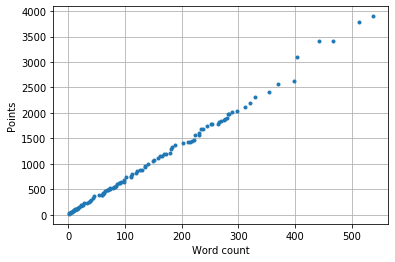

In [46]:
W, P, H, PPW = zip(*ph)

def plot(xlabel, X, ylabel, Y): 
    plt.plot(X, Y, '.'); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.grid(True)
                                    
plot('Word count', W, 'Points', P)

That was somewhat surprising to me; usually a Pareto frontier looks like a quarter-circle; here it looks like an almost straight line. Maybe we can get a better view by plotting word counts versus the number of points per word:

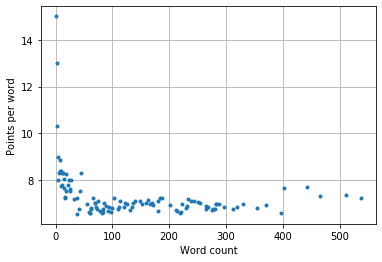

In [47]:
plot('Word count', W, 'Points per word', PPW)

So the highest points per word are for honeycombs with very few words. We can see all the Pareto optimal honeycombs that score more than, say,  7.6 points per word:

In [48]:
[entry for entry in ph if entry[-1] > 7.6]

[(1, 15, Honeycomb(letters='BIMNRUV', center='V'), 15.0),
 (2, 26, Honeycomb(letters='DHNORTX', center='X'), 13.0),
 (3, 31, Honeycomb(letters='CILMOQU', center='Q'), 10.33),
 (4, 32, Honeycomb(letters='BGINOUX', center='X'), 8.0),
 (5, 45, Honeycomb(letters='CEGIPTX', center='G'), 9.0),
 (6, 50, Honeycomb(letters='DELNPUZ', center='Z'), 8.33),
 (7, 62, Honeycomb(letters='BGILNOX', center='X'), 8.86),
 (8, 67, Honeycomb(letters='DGINOXZ', center='X'), 8.38),
 (9, 70, Honeycomb(letters='EFNQRTU', center='Q'), 7.78),
 (10, 84, Honeycomb(letters='CENOQRU', center='Q'), 8.4),
 (11, 86, Honeycomb(letters='GINOTUV', center='V'), 7.82),
 (12, 100, Honeycomb(letters='GILMNUZ', center='Z'), 8.33),
 (13, 108, Honeycomb(letters='GINOQTU', center='Q'), 8.31),
 (14, 113, Honeycomb(letters='CINOTXY', center='X'), 8.07),
 (15, 115, Honeycomb(letters='DGINOXZ', center='Z'), 7.67),
 (19, 157, Honeycomb(letters='DEIORXZ', center='X'), 8.26),
 (22, 172, Honeycomb(letters='DEGINPZ', center='Z'), 7.82),
 (

The last two of these represent our old optimal honeycomb, with two different centers.

Here are reports on what I think are the most interesting high-score/few-words honeycombs:

In [49]:
report(Honeycomb('CEGIPTX', 'G'))

Honeycomb(letters='CEGIPTX', center='G') scores 45 points on 5 words from a 44585 word list:

CEGIPTX  17 points 1 pangram  EPEXEGETIC(17)
 CEGITX   8 points  1 word  EXEGETIC(8)
  CEGIP   7 points  1 word  EPIGEIC(7)
   EGIP   6 points  1 word  PIGGIE(6)
   EGTX   7 points  1 word  EXEGETE(7)


In [50]:
report(Honeycomb('DEIORXZ', 'X'))

Honeycomb(letters='DEIORXZ', center='X') scores 157 points on 19 words from a 44585 word list:

DEIORXZ  65 points 4 pangrams DEOXIDIZER(17) OXIDIZER(15) REOXIDIZE(16) REOXIDIZED(17)
 DEIOXZ  34 points  4 words DEOXIDIZE(9) DEOXIDIZED(10) OXIDIZE(7) OXIDIZED(8)
  DEIOX  23 points  4 words DIOXIDE(7) DOXIE(5) EXODOI(6) OXIDE(5)
  DEORX  12 points  2 words REDOX(5) XEROXED(7)
   DEIX   5 points  1 word  DEXIE(5)
   DIOX  13 points  3 words DIOXID(6) IXODID(6) OXID(1)
   EORX   5 points  1 word  XEROX(5)


In [51]:
report(Honeycomb('ACINOTV', 'V'))

Honeycomb(letters='ACINOTV', center='V') scores 374 points on 45 words from a 44585 word list:

ACINOTV 171 points 10 pangrams ACTIVATION(17) AVOCATION(16) CAVITATION(17) CONVOCATION(18) INACTIVATION(19)
        INVOCATION(17) VACATION(15) VACCINATION(18) VATICINATION(19) VOCATION(15)
 ACINOV   7 points  1 word  AVIONIC(7)
 ACINTV   8 points  1 word  CAVATINA(8)
 AINOTV  62 points  7 words AVIATION(8) INNOVATION(10) INVITATION(10) NOVATION(8) OVATION(7) TITIVATION(10)
        VITIATION(9)
 CINOTV  17 points  2 words CONVICT(7) CONVICTION(10)
  ACINV  20 points  3 words VACCINA(7) VACCINIA(8) VINCA(5)
  ACITV  24 points  4 words ATAVIC(6) VATIC(5) VIATIC(6) VIATICA(7)
  ACNTV   6 points  1 word  VACANT(6)
  ACOTV   6 points  1 word  OCTAVO(6)
  AINOV   5 points  1 word  AVION(5)
  CINOV  11 points  2 words COVIN(5) OVONIC(6)
   AINV   7 points  3 words AVIAN(5) VAIN(1) VINA(1)
   AITV   6 points  2 words VITA(1) VITTA(5)
   ANOV   1 point   1 word  NOVA(1)
   ANTV   5 points  1 word  AV

In [52]:
report(Honeycomb('ACINOTU', 'U'))

Honeycomb(letters='ACINOTU', center='U') scores 385 points on 55 words from a 44585 word list:

ACINOTU 162 points 10 pangrams ACTUATION(16) ANNUNCIATION(19) AUCTION(14) CAUTION(14) CONTINUA(15)
        CONTINUANT(17) CONTINUATION(19) COUNTIAN(15) CUNCTATION(17) INCAUTION(16)
 ACINTU   6 points  1 word  TUNICA(6)
 ACNOTU  31 points  4 words ACCOUNT(7) ACCOUNTANT(10) COCOANUT(8) TOUCAN(6)
 AINOTU  17 points  2 words ANTIUNION(9) NUTATION(8)
 CINOTU  24 points  3 words CONTINUO(8) INUNCTION(9) UNCTION(7)
  ACINU   5 points  1 word  UNCIA(5)
  ACOTU   6 points  1 word  OUTACT(6)
  AINTU   9 points  1 word  ANNUITANT(9)
  CINOU  13 points  2 words INCONNU(7) NUNCIO(6)
  CINTU  10 points  2 words CUTIN(5) TUNIC(5)
  CNOTU  20 points  3 words COCONUT(7) COUNT(5) OUTCOUNT(8)
  INOTU  16 points  2 words INTUITION(9) TUITION(7)
   AINU   1 point   1 word  UNAI(1)
   ANTU  13 points  4 words AUNT(1) NUTANT(6) TAUNT(5) TUNA(1)
   AOTU   1 point   1 word  AUTO(1)
   CINU   7 points  2 words UNCI(1

# Step 11: NY Times Archives

What do the official honeycombs in the NY Times look like?  I looked for an archive of past puzzles and found a nice [github repository](https://github.com/philshem/scrape_bee) by [Philip Shemella](https://smalldata.dev/#about), from which I extracted the following honeycombs, where the first letter is the center:

In [53]:
nyt_archive = '''
ABCGILO ABGNORZ ACDIMNY ACEGHNX ACEHIMN ACINTVY ACIPTVY ACLNTVY ADEGIKN ADFLMPU ADFPRTU ADHILNR ADMOPRU AEFHLTU 
AEGHLNO AEHLPUV BACILMY BACLNOR BAELNOP BAGHINT BAILNRT BEFILNO BEFILNX BEGIKNP BILMOTY CABEILT CABJKOT CADGINR 
CADHINP CAEGHIN CAGILNW CAHIMRT CAINOTZ CAIPTVY CDEKNTU CGHINOP CHIKMNU CINOTUY DAGINPT DAGINTU DAKORWY DAMNORT 
DBILNOW DCENOVY DHILNOW DIMORTY EABCHLW EABGMTY EABKLNO EACGHLN EACNTUX EAGHIMT EAHILVY EBLOPTY ECDLMOY ECFHILY 
ECFLNOU ECHNTUY ECLMOPX ECNOPTY EDFLOUY EFGLNUV EGHILNW FAEGLOP FAELMOT GDEILTU GFHLOTU HACEMNT HACGILR HACILNR 
HACLNTU HADGILN HAELPTY HCDEIKL HDEGITW IABCFKL IABEMNT IADFLNW IADLNTW IADLPTU IAEMNTY IAFNRTY IAJMNRU IALOTVY 
ICDEFNO ICENOTV ICFNORT ICFNOTU ICGHLOR ICGLORW ICHKOPT ICLMPTY ICLNORY IDGNOXZ IEGHLOP IEHLNOT KAEGINP KCEHINT 
LABCKOW LABIMOX LACENOW LACFINU LACHINO LACIKOT LACIMOY LADFMPU LADGRUY LAEIJNV LAFMORU LAGINOZ LAHIRTY LAIRUXY 
LBCENOV LBEFINX LBEFIXY LDHINOP LDIQTUY LEHMNOT LEIPTVX LEMNOTU LENOPTU LFGHOTU LGHMOTY LGIMOXY LHIOPRW MABDINR 
MABEKNT MACILNT MADILOR MAHNOPT MAILNPT MAILORT MALNOWY MFLNORU MILPTUY NABDHKO NACDHIP NACIMTY NADFILW NADHIOT 
NALMOPR NALOPRU NBEILMT NCFIMOR NDOPRUW NMOPRTY OACELTY OADEFHN OADEGLY OADELNW OAEGHMP OAEHMNP OAGHMNY OAGILNY 
OAGLMRU OAKLMNW OBDGHUY OBDHLNU OBGHRTU OBHILRY OCDMNPU OCEHKLM OCFHINR OCFIMRU OCHIMNP OCIMPRY ODEIJNT ODFGHIT 
ODGHNRU OEGHMNY OEGIKNV OFHIRTW OFIKLRT OFINPRT OGHRTUW OHILMNT PABEILM PACDEHI PACEFTY PACINTY PADINOR PAEGHIN 
PAGHORT PAIRTUY PCELMOX PEGLOTY PELNOTY PHILORW PIMNORT RABCDKW RABCDKY RACINPT RAFHKOY RAGHOPT RCGHOUY RFLMNOU 
TACDKPR TACDLOR TACHLOP TADILVY TBCEILO TBILMOY TCNORUY TEGHNOU TGNORUW UACNORT UADFLMP UAJLNOR UBGILTY UCGILNO 
UCNORTY VABEGLT VAEGLUY WADHIRT WADKLRY WAEGIKN WCDELNO WDILORY WEGHILT YABLNOT YACEINT YADEHLT YADGHLR YADINOR 
YAEGILT YAGLMOP'''.split()

len(nyt_archive)

226

Spelling Bee has been online since mid-2018, so there should be around 1,000 puzzles, but the 226 in this archive is enough for my purposes. We can determine some characteristics of the past puzzles:

In [54]:
common(''.join(nyt_archive)) # Most common letters

[('A', 130),
 ('L', 126),
 ('O', 126),
 ('I', 125),
 ('N', 122),
 ('T', 101),
 ('C', 84),
 ('E', 84),
 ('H', 75),
 ('R', 68),
 ('Y', 68),
 ('D', 63),
 ('G', 62),
 ('M', 62),
 ('P', 59),
 ('U', 54),
 ('B', 41),
 ('F', 38),
 ('W', 29),
 ('K', 26),
 ('V', 17),
 ('X', 12),
 ('J', 5),
 ('Z', 4),
 ('Q', 1)]

In [55]:
common(letters[0] for letters in nyt_archive) # Most common centers

[('O', 30),
 ('L', 27),
 ('I', 21),
 ('E', 17),
 ('A', 16),
 ('C', 13),
 ('P', 13),
 ('N', 11),
 ('M', 10),
 ('B', 9),
 ('T', 9),
 ('D', 8),
 ('H', 8),
 ('R', 7),
 ('Y', 7),
 ('U', 6),
 ('W', 6),
 ('F', 2),
 ('G', 2),
 ('K', 2),
 ('V', 2)]

In [56]:
def vowels(letters): return letterset(v for v in 'AEIOUY'if v in letters)

common(vowels(p) for p in nyt_archive) # Vowels used

[('AI', 21),
 ('IO', 20),
 ('AO', 13),
 ('AEI', 12),
 ('OU', 11),
 ('AIO', 10),
 ('AIY', 10),
 ('AEO', 10),
 ('EI', 10),
 ('EIO', 8),
 ('IOY', 8),
 ('EOY', 7),
 ('AE', 6),
 ('AOU', 6),
 ('AOY', 6),
 ('EO', 6),
 ('AU', 5),
 ('AY', 4),
 ('AIU', 4),
 ('AEY', 4),
 ('AEIY', 4),
 ('EOU', 4),
 ('AIOY', 4),
 ('OUY', 4),
 ('AEU', 3),
 ('IOU', 3),
 ('IUY', 3),
 ('EU', 2),
 ('EIY', 2),
 ('AIUY', 2),
 ('OY', 2),
 ('AEOY', 2),
 ('A', 2),
 ('IU', 1),
 ('IOUY', 1),
 ('EUY', 1),
 ('EOUY', 1),
 ('EIU', 1),
 ('IY', 1),
 ('AUY', 1),
 ('AEUY', 1)]

In [57]:
common(len(vowels(p)) for p in nyt_archive) # Number of vowels used

[(3, 107), (2, 102), (4, 15), (1, 2)]

In [58]:
common(len(vowels(p).replace('Y', '')) for p in nyt_archive) # Number of vowels used, not counting 'Y'

[(2, 141), (3, 76), (1, 9)]

We can find the game score for all honeycombs in the archive and report some statistics:

In [59]:
nyt_honeycombs = [Honeycomb(letterset(letters), letters[0]) for letters in nyt_archive]

points_table = tabulate_points(enable1)
scores = [game_score2(h, points_table) for h in nyt_honeycombs]

dict(N=len(scores), min=min(scores), max=max(scores), mean=sum(scores)/len(scores))

{'N': 226, 'min': 107, 'max': 837, 'mean': 301.8407079646018}

So the scores of NY Times honeycombs range from 100 to 800 with a mean of 300; far less than the 3,898 of the optimal honeycomb. Here's a plot and a histogram of all the scores:

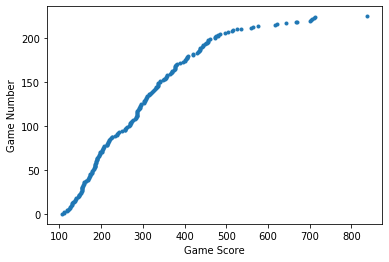

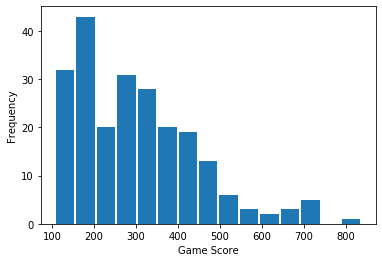

In [60]:
plt.plot(sorted(scores), range(len(scores)), '.')
plt.xlabel('Game Score'); plt.ylabel('Game Number');

plt.show()

plt.hist(scores, bins=15, rwidth=0.9)
plt.xlabel('Game Score'); plt.ylabel('Frequency');

Here's a report on the outlier, the only honeycomb to score over 800 points:

In [61]:
report(max(nyt_honeycombs, key=lambda h: game_score2(h, points_table)))

Honeycomb(letters='CEINOTV', center='I') scores 837 points on 125 words from a 44585 word list:

CEINOTV 182 points 11 pangrams COINVENT(15) CONCOCTIVE(17) CONNECTIVE(17) CONNIVENT(16) CONVECTION(17)
        CONVECTIVE(17) CONVENIENT(17) CONVENTION(17) EVECTION(15) EVICTION(15) INCONVENIENT(19)
 CEINOT 140 points 16 words CONCEIT(7) CONNECTION(10) CONTENTION(10) CONTINENCE(10) CONTINENT(9) COONTIE(7)
        INCONTINENCE(12) INCONTINENT(11) INNOCENT(8) NEOTENIC(8) NICOTINE(8) NOETIC(6) NONCONNECTION(13)
        NOTICE(6) TECTONIC(8) TONETIC(7)
 CEINOV  60 points  7 words CONCEIVE(8) CONNIVE(7) CONVENIENCE(11) CONVINCE(8) INCONVENIENCE(13) INVOICE(7)
        NOVICE(6)
 CEINTV  18 points  2 words INCENTIVE(9) INVECTIVE(9)
 CINOTV  17 points  2 words CONVICT(7) CONVICTION(10)
 EINOTV   9 points  1 word  INVENTION(9)
  CEINO  22 points  3 words CONIINE(7) CONINE(6) INNOCENCE(9)
  CEINT  20 points  3 words ENCEINTE(8) ENTICE(6) INCITE(6)
  CEINV  14 points  2 words EVINCE(6) EVINCIVE(8)
  C

And here are the most common words, along with all the pangram words that appeared more than once:

In [62]:
nyt_words = common(w for w in enable1 for h in nyt_honeycombs if can_make(h, w))
nyt_words[:30]

[('LOLL', 28),
 ('NOON', 23),
 ('LALL', 21),
 ('OLIO', 18),
 ('AALII', 16),
 ('ANNA', 16),
 ('CACA', 16),
 ('ILIA', 16),
 ('ILIAL', 16),
 ('INION', 16),
 ('NAAN', 16),
 ('NANA', 16),
 ('NINON', 16),
 ('OLLA', 16),
 ('ONION', 16),
 ('OTTO', 16),
 ('TOOT', 16),
 ('COCCI', 15),
 ('COCCIC', 15),
 ('DODO', 15),
 ('INIA', 15),
 ('LOOM', 15),
 ('LOON', 15),
 ('MOLL', 15),
 ('MOOL', 15),
 ('NOLO', 15),
 ('OLEO', 15),
 ('TITI', 15),
 ('ACACIA', 14),
 ('TOIT', 14)]

In [63]:
[(w, c) for w, c in nyt_words if c > 1 and pangram_bonus(w)]

[('CAPTIVITY', 2),
 ('COMPLEX', 2),
 ('COUNTRY', 2),
 ('HANDICAP', 2),
 ('IMMOBILITY', 2),
 ('INFLEXIBLE', 2),
 ('MOBILITY', 2),
 ('MOURNFUL', 2),
 ('NONCOUNTRY', 2),
 ('PHOTOGRAPH', 2),
 ('THOUGHTFUL', 2),
 ('WHIPPOORWILL', 2),
 ('WHIRLPOOL', 2),
 ('WINDFALL', 2),
 ('WINDFLAW', 2)]

# Step 12: 'S' Words

What if we allowed honeycombs and words to have an 'S' in them? We already saw that 53,556 words were rejected because they contain an 'S'; how much more could a honeycomb score if we allow 'S' words?

In [64]:
enable1s = valid_words(open('enable1.txt').read(), 
                       lambda w: len(w) >= 4 and len(set(w)) <= 7)

report(words=enable1s)

Best Honeycomb(letters='AEINRST', center='E') scores 8681 points on 1179 words from a 98141 word list:

AEINRST 1381 points 86 pangrams ANESTRI(14) ANTISERA(15) ANTISTRESS(17) ANTSIER(14) ARENITES(15) ARSENITE(15)
        ARSENITES(16) ARTINESS(15) ARTINESSES(17) ATTAINERS(16) ENTERTAINERS(19) ENTERTAINS(17) ENTRAINERS(17)
        ENTRAINS(15) ENTREATIES(17) ERRANTRIES(17) INERTIAS(15) INSTANTER(16) INTENERATES(18) INTERSTATE(17)
        INTERSTATES(18) INTERSTRAIN(18) INTERSTRAINS(19) INTRASTATE(17) INTREATS(15) IRATENESS(16)
        IRATENESSES(18) ITINERANTS(17) ITINERARIES(18) ITINERATES(17) NASTIER(14) NITRATES(15) RAINIEST(15)
        RATANIES(15) RATINES(14) REATTAINS(16) REINITIATES(18) REINSTATE(16) REINSTATES(17) RESINATE(15)
        RESINATES(16) RESISTANT(16) RESISTANTS(17) RESTRAIN(15) RESTRAINER(17) RESTRAINERS(18) RESTRAINS(16)
        RESTRAINT(16) RESTRAINTS(17) RETAINERS(16) RETAINS(14) RETINAS(14) RETIRANTS(16) RETRAINS(15)
        RETSINA(14) RETSINAS(15) SANITARIES

Allowing 'S' words more than doubles the score!

Here are pictures for the highest-scoring honeycombs, with and without an S:

<img src="http://norvig.com/honeycombs.png" width="350">
<center>
   537 words; 3,898 points &nbsp; &nbsp; &nbsp; &nbsp; 1,179 words; 8,681 points
    <br>
</center>

# Summary

This notebook showed how to find the highest-scoring honeycomb. Four ideas led to four approaches:

1. **Brute Force Enumeration**: Compute the game score for every possible honeycomb; return the best.
2. **Pangram Lettersets**: Compute the game score for just the honeycombs that are pangram lettersets (with all possible centers).
3. **Points Table**: Precompute the score for each letterset; then for each candidate honeycomb, sum the scores of the 64 letter subsets.
4. **Branch and Bound**: Try all 7 centers only for lettersets that score better than the best score so far.

These ideas led to a substantial reduction in the number of honeycombs  examined (a factor of 400), the run time of a call to `game_score` (a factor of 300), and the overall run time of `best_honeycomb` (a factor of  75,000, although I didn't actually run the first two cases, just estimated the time).

|Approach|Honeycombs|`game_score` Time|Total Run Time|
|--------|----------|--------|----|
|**1. Brute Force Enumeration**|3,364,900|9000 microseconds|8.5 hours|
|**2. Pangram Lettersets**|55,902|9000 microseconds|500 seconds|
|**3. Points Table**|55,902|26 microseconds|1.6 seconds|
|**4. Branch and Bound**|8,084 |26 microseconds|0.4 seconds|

